In [1]:
#!pip install --upgrade pillow

In [2]:
%matplotlib widget
import os
import csv
from pathlib import Path
import pandas as pd
import numpy as np
#import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#%matplotlib inline



hole_indexes = ['2-5', '2-6', '3-2', '3-3', '4-5']
filenames = [idx + " - Borehole Deviation Data.csv" for idx in hole_indexes]

source_folder = Path(r'C:\Users\howar\OneDrive - ballingercloud\Documents\umb boreholes')
filepaths = [source_folder / fn for fn in filenames]

In [3]:
# crate dataframe of first borehole
# TODO dataframes of all boreholes
df = pd.read_csv(filepaths[1])
df.dropna(inplace=True)
df.set_axis(['idx', 'dz', 'dy', 'dx', 'total_dev_ft', 'total_dev_pct'], axis=1, inplace=True)
df = df[0::10] # only getting entries every 10 linear feet, could remove for every 1 foot spacing
df.tail()

,idx,dz,dy,dx,total_dev_ft,total_dev_pct
560,560.0,559.0,10.2,14.4,17.7,3.2
570,570.0,568.9,10.9,14.7,18.3,3.2
580,580.0,578.9,11.6,14.9,18.9,3.3
590,590.0,588.9,12.3,15.2,19.5,3.3
600,600.0,598.8,12.9,15.5,20.2,3.4


In [4]:
df.head()

,idx,dz,dy,dx,total_dev_ft,total_dev_pct
0,0.0,0.0,0.0,0.0,0.0,0.0
10,10.0,10.0,-0.1,0.0,0.1,0.7
20,20.0,20.0,-0.1,0.0,0.1,0.7
30,30.0,30.0,-0.2,0.0,0.2,0.7
40,40.0,40.0,-0.3,0.0,0.3,0.7


In [5]:
# calculate the differences in each xyz
# these values form the components of the vector from the previous location

df['delta_dx'] = df['dx'] - df['dx'].shift(1, fill_value=None)
df['delta_dy'] = df['dy'] - df['dy'].shift(1, fill_value=None)
df['delta_dz'] = df['dz'] - df['dz'].shift(1, fill_value=None)

# to get the change in direction, need to get the difference between this delta and previous delta

df['ddx'] = df['delta_dx'] - df['delta_dx'].shift(1, fill_value=None)
df['ddy'] = df['delta_dy'] - df['delta_dy'].shift(1, fill_value=None)
df['ddz'] = df['delta_dz'] - df['delta_dz'].shift(1, fill_value=None)

df.loc[df['ddx'].abs() < 0.001, 'ddx'] = 0
df.loc[df['ddy'].abs() < 0.001, 'ddy'] = 0
df.loc[df['ddz'].abs() < 0.001, 'ddz'] = 0

df.tail()



,idx,dz,dy,dx,total_dev_ft,total_dev_pct,delta_dx,delta_dy,delta_dz,ddx,ddy,ddz
560,560.0,559.0,10.2,14.4,17.7,3.2,0.2,0.6,10.0,-0.1,-0.1,0.0
570,570.0,568.9,10.9,14.7,18.3,3.2,0.3,0.7,9.9,0.1,0.1,-0.1
580,580.0,578.9,11.6,14.9,18.9,3.3,0.2,0.7,10.0,-0.1,0.0,0.1
590,590.0,588.9,12.3,15.2,19.5,3.3,0.3,0.7,10.0,0.1,0.0,0.0
600,600.0,598.8,12.9,15.5,20.2,3.4,0.3,0.6,9.9,0.0,-0.1,-0.1


In [6]:
bins = np.arange(-0.3, 0.3, 0.02)
bins

array([-3.00000000e-01, -2.80000000e-01, -2.60000000e-01, -2.40000000e-01,
       -2.20000000e-01, -2.00000000e-01, -1.80000000e-01, -1.60000000e-01,
       -1.40000000e-01, -1.20000000e-01, -1.00000000e-01, -8.00000000e-02,
       -6.00000000e-02, -4.00000000e-02, -2.00000000e-02,  2.77555756e-16,
        2.00000000e-02,  4.00000000e-02,  6.00000000e-02,  8.00000000e-02,
        1.00000000e-01,  1.20000000e-01,  1.40000000e-01,  1.60000000e-01,
        1.80000000e-01,  2.00000000e-01,  2.20000000e-01,  2.40000000e-01,
        2.60000000e-01,  2.80000000e-01])

In [7]:
#df[['ddx', 'ddy', 'ddz']]

In [8]:
#df[['ddx', 'ddy', 'ddz']].plot(kind='hist', bins=bins,subplots=True, title=['ddx', 'ddy', 'ddz'])

In [9]:
stats_list = ["min", "max", "mean", "median", "std", "skew"]
df.agg(
{
    "delta_dx": stats_list,
    "delta_dy": stats_list,
    "delta_dz": stats_list,
    "ddx": stats_list,
    "ddy": stats_list,
    "ddz": stats_list,
}
)

,delta_dx,delta_dy,delta_dz,ddx,ddy,ddz
min,-0.100000,-0.500000,9.900000,-0.200000,-0.200000,-0.100000
max,0.600000,0.800000,10.000000,0.200000,0.200000,0.100000
mean,0.258333,0.215000,9.980000,0.005085,0.011864,-0.001695
median,0.300000,0.500000,10.000000,0.000000,0.000000,0.000000
std,0.163947,0.490874,0.040338,0.095455,0.085268,0.062949
skew,-0.152911,-0.217161,-1.538739,-0.104015,0.284759,0.012085


In [10]:
#p1 = df.iloc[50, 6:9]
#p2 = df.iloc[51, 6:9]
#print(f"p1: {p1}\np2:{p2}\ndot: {p1.dot(p2)}")

In [11]:
#cols = df.columns[6:9]
#df['dot'] = (df[cols] * df[cols].shift(1)).sum(axis=1)
#df['dot'].std()

In [12]:
#df[2:].plot(x="idx", y="dot")

In [13]:
#df[abs(df["dot"] - 1) > 0.03 ].head()

In [14]:
#df.plot(x='idx', y='delta_dy')

In [15]:
#df.plot(x='idx', y='delta_dx')

In [16]:
#df[2:].plot(x='idx', y=['delta_dx', 'delta_dy'])

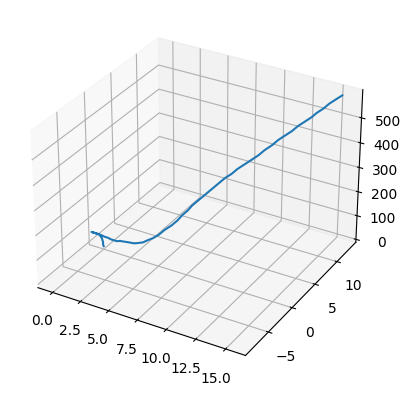

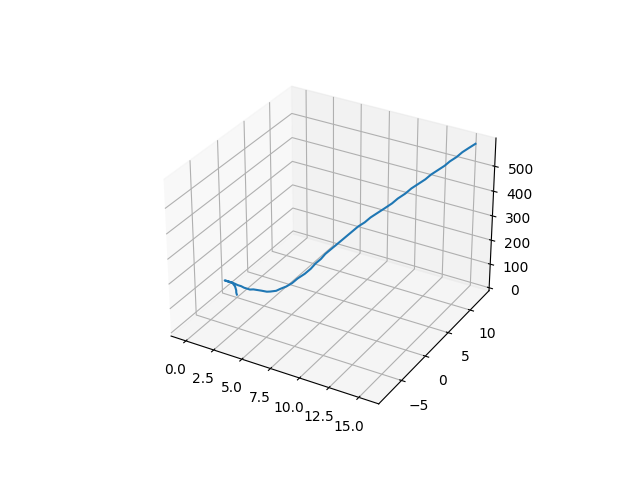

In [20]:
#ax = matplotlib.pyplot.figure().add_subplot(projection='3d')
#ax.plot(df['dx'][2:], df['dy'][2:], df['dz'][2:], label='test borehole plot')
#plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(df['dx'], df['dy'], df['dz'], label='test borehole plot')
#plt.show()
fig
